## Main EMR code

In [653]:
project_path = "../../../../../"
utils_path = project_path * "src/utils/"

output_directory = project_path * "data/output/case_1/kerr/";

In [654]:

cd(@__DIR__)
using Pkg; Pkg.activate(project_path); 
Pkg.instantiate();
using OrdinaryDiffEq;
using Optim;
using LineSearches;
using DiffEqFlux;
using DiffEqSensitivity;
using Plots;
using DataFrames;
using CSV;
using Statistics;
using Flux;
using Random;
import BSON: @save, @load
import StatsBase: sample
# gr(); # specify backend for plotting

include(utils_path * "utils.jl")
import_project_utils(utils_path);

seeds and data paths

In [655]:
# specify random seed
seed = 1234;
Random.seed!(seed)

# script conditions
show_plots = true
save_plots_gif = true
save_data = false

# paths
test_name = "kerr_from_schwarzschild_modified/"
model_name = "kerr_from_schwarzschild_modified/" #"encoder/" #

output_dir = output_directory* "models/" * test_name
solutions_dir = output_dir * "solutions/"
metrics_dir = output_directory * "metrics/"
img_dir = output_dir * "train_img_for_gif/"
list_directories = (output_dir, solutions_dir, metrics_dir, img_dir)
create_directories(list_directories)

Define neural network model

In [656]:
function nn_model_case1_arch1_modified(number_of_neurons_in_hidden_layer::Int64, activation_function; type::String = "standard")
    """
    Define multiple configurations of architecture of type 1
    # softmodulusQ, leakyrelu, relu, cos, tanh, abs, sigmoid
    """

    if type == "standard"
        chain = Chain(
            # x = [χ, ϕ, a, p, M, e]
            # x -> Float32.([cos(x[1]), sin(x[1]), x[3], 1/x[3], 1/x[3]^3, x[3]^2, x[3]^3, 1/x[3]^2]),
            # Dense(8, number_of_neurons_in_hidden_layer, activation_function),
            x -> Float32.([cos(x[1]), x[3]]),
            Dense(2, Int(number_of_neurons_in_hidden_layer/2), activation_function),
            Dense(Int(number_of_neurons_in_hidden_layer/2), number_of_neurons_in_hidden_layer, activation_function),
            Dense(number_of_neurons_in_hidden_layer, Int(number_of_neurons_in_hidden_layer/2), activation_function),
            Dense(Int(number_of_neurons_in_hidden_layer/2), Int(number_of_neurons_in_hidden_layer/2), activation_function),
            Dropout(0.8),
            Dense(Int(number_of_neurons_in_hidden_layer/2), 2)
        )
        # chain = Chain(
        #     # x = [χ, ϕ, a]
        #     x -> Float32.([cos(x[1])]),
        #     Dense(1, number_of_neurons_in_hidden_layer, activation_function),
        #     Dense(number_of_neurons_in_hidden_layer, number_of_neurons_in_hidden_layer, activation_function),
        #     Dense(number_of_neurons_in_hidden_layer, 2)
        # )
    end

    NN, NN_params, chain, re = process_chain(chain)

    return NN, NN_params, chain, re
end

NN, NN_params, chain, re = nn_model_case1_arch1_modified(32, relu);
# NO: tanh

(NN, [-0.003864526450634003, 0.0009221682697534561, 0.0015216048061847687, -0.0010242874920368195, -0.0010646625608205795, 0.005451757907867432, -0.004613058269023895, -0.005601350665092469, -0.0016898584365844726, 0.0002350391261279583  …  -0.005034453272819519, 0.002640407681465149, -0.0031454917788505555, -0.0044543233513832095, -0.0012441746145486832, -0.002957257628440857, 0.00496122807264328, 0.004483031630516052, 0.0, 0.0], Chain(#5385, Dense(2 => 16, relu), Dense(16 => 32, relu), Dense(32 => 16, relu), Dense(16 => 16, relu), Dropout(0.8), Dense(16 => 2)), Restructure(Chain, ..., 1426))

Define dataset

In [657]:
datasize = 250
mass_ratio = 0.0
dt = 100.0

# TRAIN waveform parameters

χ₀ = Float64(pi/2); 
ϕ₀ = Float64(0.0);
p_space = [20.0]
M=Float64(1.0);
e = Float64(0.5)
tspan_train = (0, 6.0e3)
a_space = Float64.([0.01, 0.10, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

train_info = [];
for a in a_space 
    for p in p_space
        train_info_i = get_pinn_EMR_schwarzschild_modified(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_train, datasize, dt);
        true_info = get_true_solution_EMR_kerr(train_info_i["u0"], train_info_i["model_params"], mass_ratio, M, train_info_i["tspan"], train_info_i["tsteps"], train_info_i["dt_data"], dt)
        push!(train_info, merge(train_info_i, true_info))
    end
end

# TEST waveform parameters

p = 20.0
factor = 1
datasize = datasize * factor
tspan_test = (tspan_train[1], tspan_train[2]*factor)
a_space = Float64.([1e-5, 0.35, 0.5, 0.85])

test_info = [];
for a in a_space
    test_info_i = get_pinn_EMR_schwarzschild_modified(χ₀, ϕ₀, p, M, e, a, mass_ratio, tspan_test, datasize, dt);
    true_info = get_true_solution_EMR_kerr(test_info_i["u0"], test_info_i["model_params"], mass_ratio, M, test_info_i["tspan"], test_info_i["tsteps"], test_info_i["dt_data"], dt)
    push!(test_info, merge(test_info_i, true_info))
end

# put data in arrays
println("Processing datasets")
datasets = Dict("train" => train_info, "test" => test_info)
processed_data = process_datasets(datasets);

Let's see train waveform differences

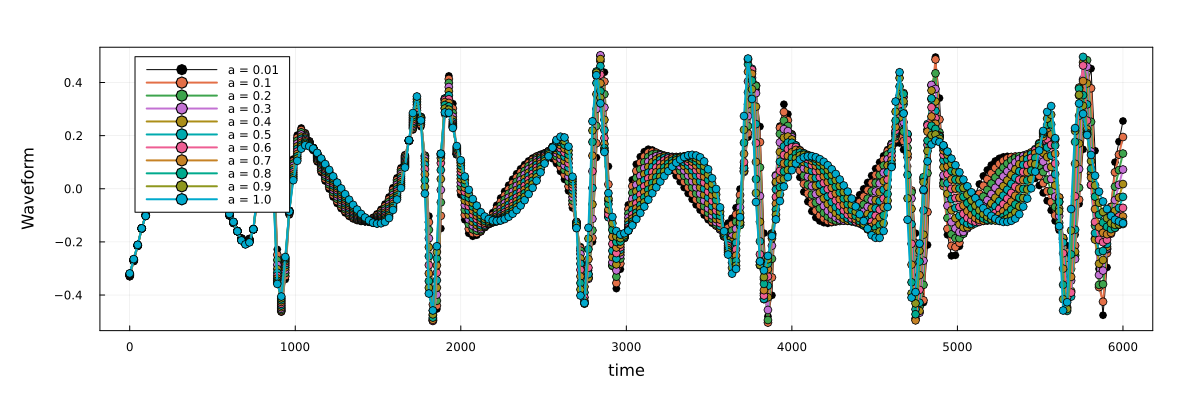

In [658]:
example = processed_data["train"][1]
waveforms_plot = plot(
    example["tsteps"],
    example["true_waveform"],
    label= "a = "*string(example["model_params"][4]),
    size=(1200,400),
    margin=10Plots.mm,
    framestyle=:box,
    ylabel="Waveform",
    xlabel="time",
    markersize=4,
    marker=:o,
    color=:black,
)
for index in 2:length(processed_data["train"])
    example = processed_data["train"][index]
    plot!(
        waveforms_plot,
        example["tsteps"],
        example["true_waveform"],
        label= "a = " * string(example["model_params"][4]),
        marker=:o,
        # markersize=4,
        linewidth=2,
    )
end
waveforms_plot

Let's see the approximation of our PINN model before training

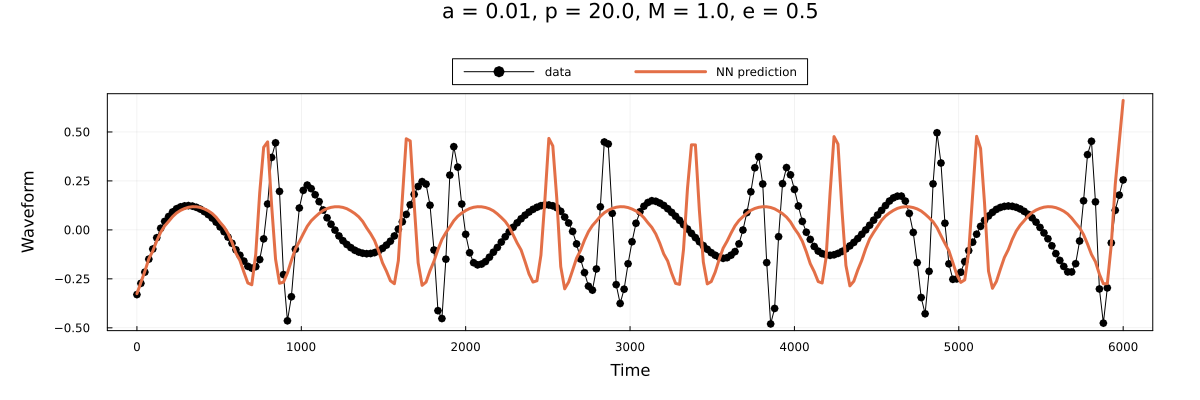

In [659]:
# zero training image

example = processed_data["train"][1]
zero_training_solution = Array(solve(
    example["nn_problem"],
    RK4(), 
    saveat = example["tsteps"], 
    dt = dt, 
    adaptive=false
))
pred_waveform, _ = compute_waveform(example["dt_data"], zero_training_solution, example["q"], example["M"], example["model_params"])
title = create_waveform_title(example["model_params"][1], example["model_params"][2], example["model_params"][3], example["model_params"][4])
zero_training_plt = train_plot(example["tsteps"], example["true_waveform"], pred_waveform, size=(1200,400), title=title)

Train our PINN

In [660]:

function loss_function_case1_single_waveform(
    pred_sol::Matrix{Float64},
    true_waveform::Vector{Float64},
    dt_data, 
    model_params::Vector{Float64},
    NN_params::Vector{Float64} = nothing;
    tsteps=nothing,
    loss_function::String = "mae",
    coef_data::Float64 = 1.0,
    coef_weights::Float64 = 0.1
    )
    """
    Calculate loss function for a single EMR system
    """

    mass_ratio = 0
    p, M, e, a = model_params
    pred_waveform, _ = compute_waveform(dt_data, pred_sol, mass_ratio, M, model_params)

    if loss_function == "mae"
        loss = coef_data*Flux.Losses.mae(pred_waveform, true_waveform) + coef_weights*sum(abs2, NN_params)
    elseif loss_function == "mse"
        loss = Flux.Losses.mse(pred_waveform, true_waveform)
    elseif loss_function == "huber"
        loss = Flux.Losses.huber_loss(pred_waveform, true_waveform, δ=0.01)
    elseif loss_function == "original"
        loss = sum(abs2, true_waveform .- pred_waveform)
    end

    metric = Flux.Losses.mse(pred_waveform, true_waveform)

    loss_information = Dict{String, Any}()
    loss_information["loss"] = loss
    loss_information["metric"] = metric
    loss_information["pred_waveform"] = pred_waveform
    loss_information["true_waveform"] = true_waveform
    loss_information["tsteps"] = tsteps
    loss_information["model_params"] = model_params

    return loss_information
end


function loss_function_case1(NN_params::Vector{Float64}; processed_data, batch_size::Int64 = nothing, loss_function_name::String = "mae")
    """
    Loss function for a set of EMR systems
    """

    train_loss = 0
    train_metric = 0
    test_loss = 0
    test_metric = 0

    local train_loss_information, test_loss_information

    train_subset = get_data_subset(processed_data["train"], batch_size)
    test_subset = get_data_subset(processed_data["test"], batch_size)

    for train_item in train_subset

        prob_nn_train = train_item["nn_problem"]
        exact_waveform_train = train_item["true_waveform"]
        tsteps_train = train_item["tsteps"]
        tspan_train = train_item["tspan"]
        model_params_train = train_item["model_params"]
        u0_train = train_item["u0"]
        dt_data_train = train_item["dt_data"]

        pred_sol_train = Array(solve(remake(prob_nn_train, u0=u0_train, p = NN_params, tspan=tspan_train), RK4(), saveat = tsteps_train, dt = dt, adaptive=false))
        train_loss_information = loss_function_case1_single_waveform(pred_sol_train, exact_waveform_train, dt_data_train, model_params_train, NN_params, tsteps=tsteps_train, loss_function=loss_function_name)

        train_loss += abs(train_loss_information["loss"])
        train_metric += abs(train_loss_information["metric"])
    end

    for test_item in test_subset
        prob_nn_test = test_item["nn_problem"]
        exact_waveform_test = test_item["true_waveform"]
        tsteps_test = test_item["tsteps"]
        tspan_test = test_item["tspan"]
        model_params_test = test_item["model_params"]
        u0_test = test_item["u0"]
        dt_data_test = test_item["dt_data"]

        pred_sol_test = Array(solve(remake(prob_nn_test, u0=u0_test, p = NN_params, tspan=tspan_test), RK4(), saveat = tsteps_test, dt = dt, adaptive=false))
        test_loss_information = loss_function_case1_single_waveform(pred_sol_test, exact_waveform_test, dt_data_test, model_params_test, NN_params, tsteps=tsteps_test, loss_function=loss_function_name)

        test_loss += abs(test_loss_information["loss"])
        test_metric += abs(test_loss_information["metric"])
    end

    train_loss = train_loss / length(processed_data["train"])
    train_metric = train_metric / length(processed_data["train"])
    test_metric = test_metric / length(processed_data["test"])
    test_loss = test_loss / length(processed_data["test"])
    
    agregated_metrics = Dict("train_loss" => train_loss, "test_loss" => test_loss, "train_metric" => train_metric, "test_metric" => test_metric)

    # we must give the loss value as first argument
    return [train_loss, agregated_metrics, train_loss_information, test_loss_information]
end

loss_function_case1 (generic function with 1 method)

In [661]:

train_losses = []
test_losses = []
train_metrics = []
test_metrics = []
plot_list = []
weights = []

show_plots = true

callback_EMR(θ::Vector{Float64}, train_loss::Float64, agregated_metrics::Dict{String, Float64}, train_loss_information::Dict, test_loss_information::Dict; show_plots::Bool = show_plots, save_plots_gif::Bool=save_plots_gif) = begin

    # add losses
    push!(train_losses, agregated_metrics["train_loss"])
    push!(test_losses, agregated_metrics["test_loss"])
    push!(train_metrics, agregated_metrics["train_metric"])
    push!(test_metrics, agregated_metrics["test_metric"])
    push!(weights, θ)

    if show_plots
        # train waveform
        title = create_waveform_title(train_loss_information["model_params"][1], train_loss_information["model_params"][2], train_loss_information["model_params"][3], train_loss_information["model_params"][4])
        plt1 = train_plot(train_loss_information["tsteps"], train_loss_information["true_waveform"], train_loss_information["pred_waveform"], title=title)

        # test waveform
        title = create_waveform_title(test_loss_information["model_params"][1], test_loss_information["model_params"][2], test_loss_information["model_params"][3], test_loss_information["model_params"][4])
        plt2 = test_plot(train_loss_information["tsteps"], test_loss_information["tsteps"], test_loss_information["true_waveform"], test_loss_information["pred_waveform"], title=title)

        l = @layout [a; b]
        plt = plot(plt1, plt2, layout=l)
        if save_plots_gif
            push!(plot_list, plt)
        end
    end

    return false
end

loss_f(p) = loss_function_case1(p, processed_data=processed_data, batch_size=4, loss_function_name="mae")

adtype = Optimization.AutoZygote()
optfunct = Optimization.OptimizationFunction((x, p) -> loss_f(x), adtype)
optprob = Optimization.OptimizationProblem(optfunct, NN_params)

res = Optimization.solve(
    optprob,
    Flux.Optimise.ADAM(0.001), # cos ->
    # Flux.Optimise.ADAM(0.0001), # [1.0, 10.0, 15.0, 5.0] and p = 100.0 and [0, 6.3] and batch_size = 5-7
    # BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()), # -> 1 waveform overfitting
    callback=callback_EMR,
    maxiters=50
);

In [662]:
# train by steps -> progresively as seen in experiments 2 reference paper

Loss function

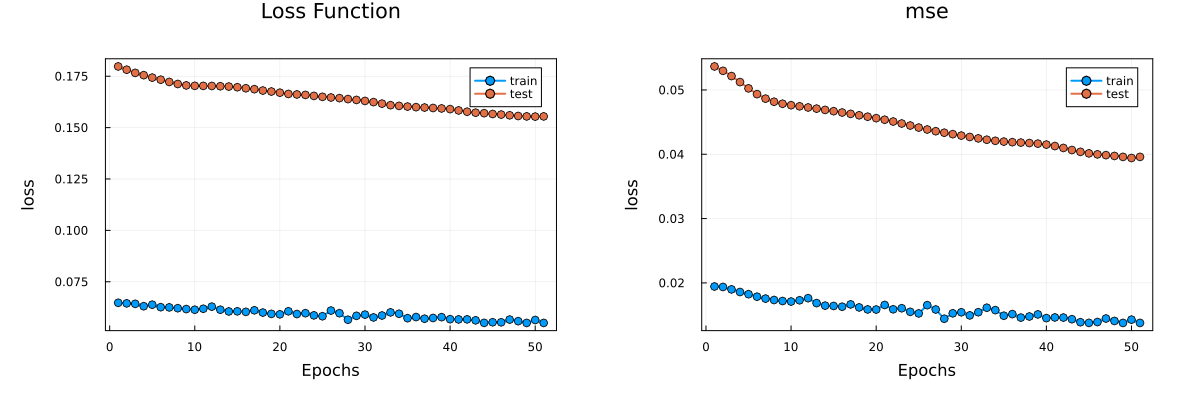

In [664]:
plot_losses = plot(train_losses, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="Loss Function")
plot!(plot_losses, test_losses, label="test", marker=:o, linewidth=2)

plot_mse = plot(train_metrics, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="mse")
plot!(plot_mse, test_metrics, label="test", marker=:o, linewidth=2)

plot_metrics = plot(plot_losses, plot_mse, layout=(1,2), size=(1200,400), margin=10Plots.mm)

See last epoch predictions

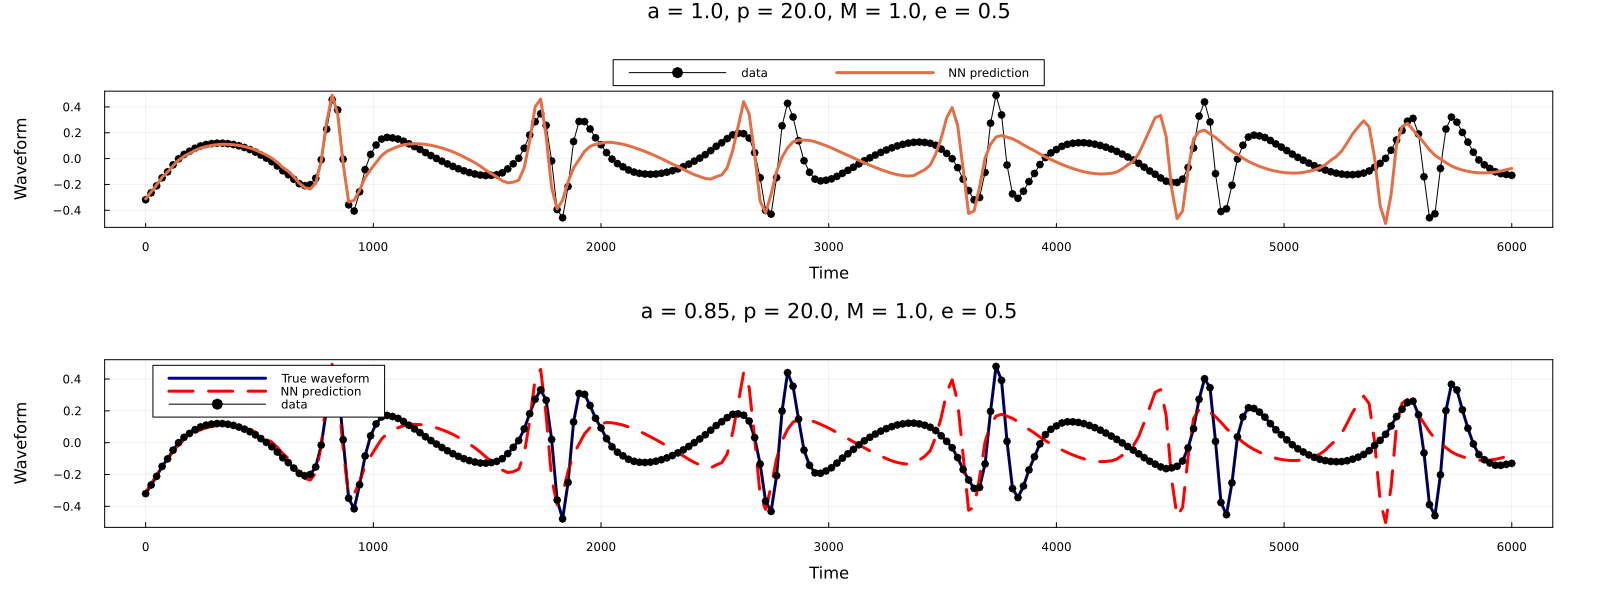

In [666]:
best_test_epoch = findmin(test_losses)[2]
print("Best epoch: ", best_test_epoch)
prediction_plot = plot(plot_list[best_test_epoch])

In [153]:
savefig(prediction_plot, "./prediction_plot.png")
# savefig(plot_metrics, "./plot_metrics.png")

"/home/rubenbalbastre/Escritorio/TFM/code/01_project/src/processing/experiments/kerr/case_1/prediction_plot.png"

Save model weights

In [615]:
# save flux chain models as bson files. To do so, we must save chain model with its parameters
NN_params = weights[best_test_epoch];
# Flux.loadparams!(chain, Flux.params(re(NN_params)))
# @save solutions_dir*"model_chiphi.bson" chain

1426-element Vector{Float64}:
 -0.00011288851008278888
 -0.0002955554558325789
  9.344162720421489e-5
 -2.479141037879603e-5
 -9.519927673589469e-5
 -0.00020136722394650537
  0.00014085114690284622
 -7.401599655868596e-5
  8.750404772280972e-5
  3.2862365129704844e-5
  ⋮
 -0.003914316407614251
 -0.00659764710214775
  0.0012947119303710606
 -0.005815918841006646
  0.003842505006280562
 -0.0011196543606637709
  0.0053561743625045585
 -0.005259273968643834
  0.001470411334346218

Second training

In [625]:
NN_params = NN_params .+ 3e-6

optprob = Optimization.OptimizationProblem(optfunct, NN_params)

res = Optimization.solve(
    optprob,
    Flux.Optimise.ADAM(0.001),
    # Flux.Optimise.ADAM(0.0001), # [1.0, 10.0, 15.0, 5.0] and p = 100.0 and [0, 6.3] and batch_size = 5-7
    # BFGS(initial_stepnorm=0.01, linesearch = LineSearches.BackTracking()), # -> 1 waveform overfitting
    callback=callback_EMR,
    maxiters=50
);

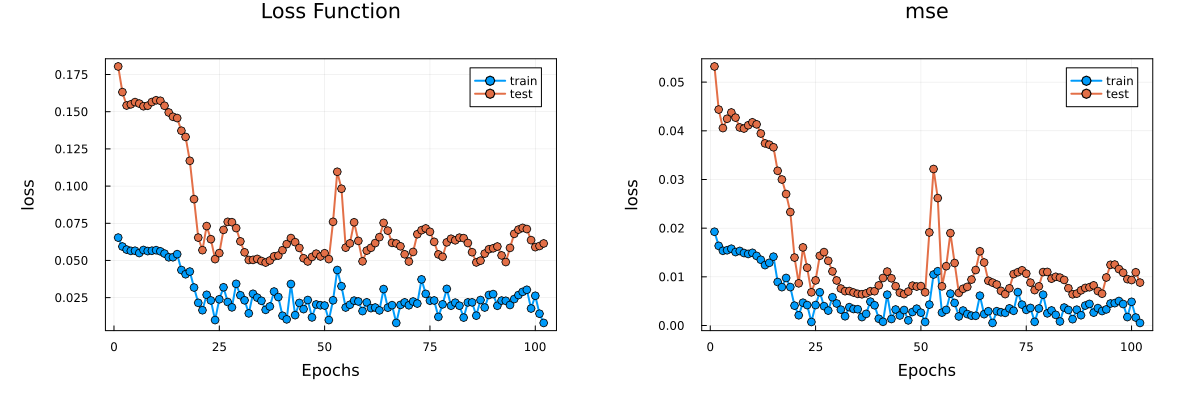

In [626]:
plot_losses = plot(train_losses, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="Loss Function")
plot!(plot_losses, test_losses, label="test", marker=:o, linewidth=2)

plot_mse = plot(train_metrics, label="train", xlabel="Epochs", ylabel="loss", framestyle=:box, marker=:o, linewidth=2, title="mse")
plot!(plot_mse, test_metrics, label="test", marker=:o, linewidth=2)

plot_metrics = plot(plot_losses, plot_mse, layout=(1,2), size=(1200,400), margin=10Plots.mm)

Save training metrics

In [24]:
# save losses
losses_df = DataFrame(
    epochs = range(1, length(train_losses)),
    test_name=test_name,
    train_loss = train_losses,
    test_loss = test_losses,
    train_metric = train_metrics,
    test_metric = test_metrics,
)

if ! isfile(metrics_dir*"losses.csv")
    CSV.write(metrics_dir*"losses.csv", losses_df)
else
    x = DataFrame(CSV.File(metrics_dir*"losses.csv", types=Dict("test_name" => String31)))
    append!(x, losses_df)
    CSV.write(metrics_dir*"losses.csv", x)
end

"../../../../../data/output/case_1/kerr/metrics/losses.csv"

Save training plots for each epoch

In [25]:
if save_data
    savefig(zero_training_plt, img_dir*"0_train_img.pdf")
    savefig(zero_training_plt, img_dir*"0_train_img.png")
    println("Save train images")
    # save plots
    for (ind, img) in enumerate(plot_list)
        savefig(img, img_dir*string(ind)*"_train_img.pdf")
        savefig(img, img_dir*string(ind)*"_train_img.png")
        if ind == length(plot_list)
            savefig(img, output_dir*"prediction_plot.pdf")
            savefig(img, output_dir*"prediction_plot.png")
        end
    end
end